## One step univariate feed-forward neural network model
In this notebook, we demonstrate how to:

- prepare time series data for training a Convolutional Neural Network (CNN) forecasting model
- get data in the required shape for the keras API
- implement a CNN model in keras to predict the next step ahead (time t+1) in the time series
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition1. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load. In this example, we show **how to forecast one time step ahead**, using historical load data only.

1Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [32]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from glob import glob
from IPython.display import Image
%matplotlib inline

In [33]:
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [34]:
data_dir = './data'
# load the csv file
energy = pd.read_csv(os.path.join(data_dir, 'energy.csv'), parse_dates=['timestamp'])
# make the timestamp the index
energy.index = energy['timestamp']
# split the timestamp as hour equaly sets
energy = energy.reindex(pd.date_range(min(energy['timestamp']),
                                          max(energy['timestamp']),
                                          freq='H'))
# drop the timestamp column
energy = energy.drop('timestamp', axis=1)

#select only load column
energy = energy['load']
# transform it to dataframe
energy = energy.to_frame()


## Create train, validation and test sets
We separate our dataset into train, validation and test sets. We train the model on the train set. The validation set is used to evaluate the model after each training epoch and ensure that the model is not overfitting the training data. After the model has finished training, we evaluate the model on the test set. We must ensure that the validation set and test set cover a later period in time from the training set, to ensure that the model does not gain from information from future time periods.

We will allocate the period 1st November 2014 to 31st December 2014 to the test set. The period 1st September 2014 to 31st October is allocated to validation set. All other time periods are available for the training set.

In [35]:
valid_start_dt =  '2014-09-01 00:00:00'
test_start_dt =  '2014-11-01 00:00:00'

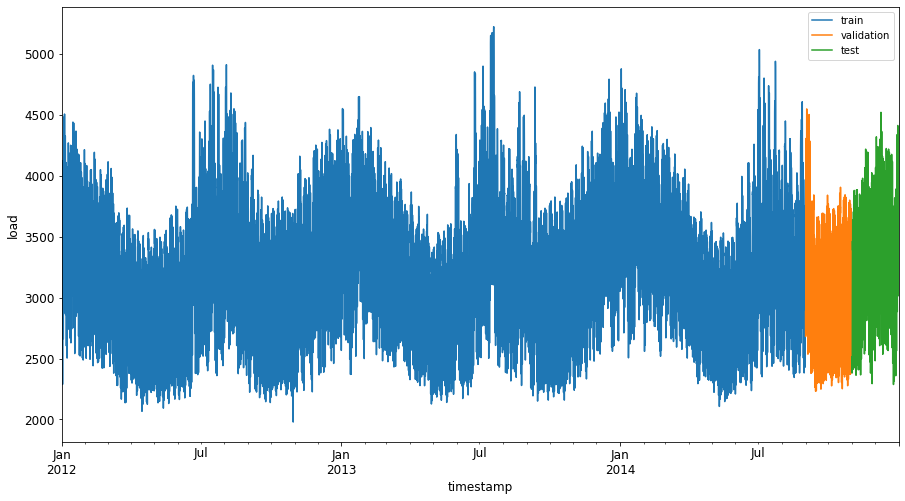

In [36]:
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'train'}) \
    .join(energy[(energy.index >=valid_start_dt) & (energy.index < test_start_dt)][['load']] \
          .rename(columns={'load':'validation'}), how='outer') \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

## Data preparation - training set
For this example, we will set T=10. This means that **the input for each sample is a vector of the previous 10 hours** of the energy load. The choice of T=10 was arbitrary but should be selected through experimentation.

HORIZON=1 specifies that we have a forecasting horizon of 1 (t+1)

In [37]:
T=6
HORIZON=1

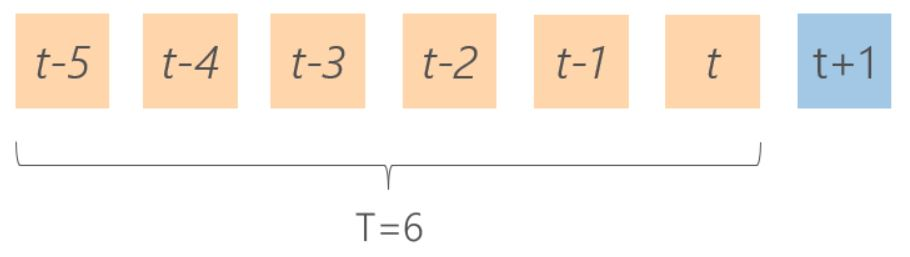

In [38]:
Image("images/one_step_forecast_T6.JPG")

## Training set data preparation

Our data preparation for the training set will involve the following steps:

- Filter the original dataset to include only that time period reserved for the training set
- **Scale the time series** such that the values fall within the interval (0, 1)
- Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
- Discard any samples with missing values
- Transform this Pandas dataframe into a numpy array of shape (samples, features) for input into Keras

In [39]:
#Filter the original dataset
train = energy.copy()[energy.index < valid_start_dt]['load']
train = train.to_frame()
# Scale the time series to intervale (0,1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head()

,load
2012-01-01 00:00:00,0.22
2012-01-01 01:00:00,0.18
2012-01-01 02:00:00,0.14
2012-01-01 03:00:00,0.13
2012-01-01 04:00:00,0.13


In [40]:
train.tail()

,load
2014-08-31 19:00:00,0.61
2014-08-31 20:00:00,0.58
2014-08-31 21:00:00,0.51
2014-08-31 22:00:00,0.43
2014-08-31 23:00:00,0.34


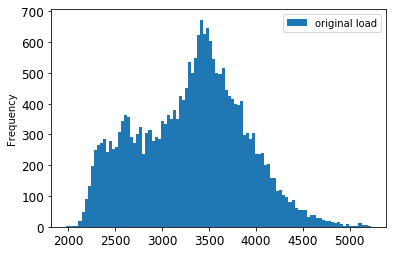

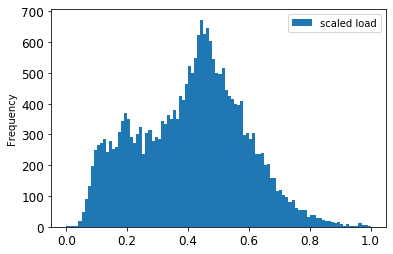

In [41]:
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)

train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

### 3. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
First, we create the target (y_t+1) variable. If we use the convention that the dataframe is indexed on time t, we need to shift the load variable forward one hour in time. Using the freq parameter we can tell Pandas that the frequency of the time series is hourly. This ensures the shift does not jump over any missing periods in the time series.

In [42]:
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['load'].shift(-1, freq='H')
train_shifted.head(10)

,load,y_t+1
2012-01-01 00:00:00,0.22,0.18
2012-01-01 01:00:00,0.18,0.14
2012-01-01 02:00:00,0.14,0.13
2012-01-01 03:00:00,0.13,0.13
2012-01-01 04:00:00,0.13,0.15
2012-01-01 05:00:00,0.15,0.18
2012-01-01 06:00:00,0.18,0.23
2012-01-01 07:00:00,0.23,0.29
2012-01-01 08:00:00,0.29,0.35
2012-01-01 09:00:00,0.35,0.37


We also need to shift the load variable back 9 times to create the input sequence:

In [43]:
for t in range(1,T+1):
     train_shifted['load_t-'+str(T-t)] = train_shifted['load'].shift(T-t, freq='H')
        
train_shifted = train_shifted.rename(columns={'load':'load_original'})
train_shifted.head(10)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
2012-01-01 00:00:00,0.22,0.18,nan,nan,nan,nan,nan,0.22
2012-01-01 01:00:00,0.18,0.14,nan,nan,nan,nan,0.22,0.18
2012-01-01 02:00:00,0.14,0.13,nan,nan,nan,0.22,0.18,0.14
2012-01-01 03:00:00,0.13,0.13,nan,nan,0.22,0.18,0.14,0.13
2012-01-01 04:00:00,0.13,0.15,nan,0.22,0.18,0.14,0.13,0.13
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,0.13,0.13,0.15,0.18,0.23,0.29
2012-01-01 09:00:00,0.35,0.37,0.13,0.15,0.18,0.23,0.29,0.35


### 4. Discard any samples with missing values
Notice how we have missing values for the input sequences for the first 5 samples. We will discard these:

In [44]:
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(10)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,0.13,0.13,0.15,0.18,0.23,0.29
2012-01-01 09:00:00,0.35,0.37,0.13,0.15,0.18,0.23,0.29,0.35
2012-01-01 10:00:00,0.37,0.37,0.15,0.18,0.23,0.29,0.35,0.37
2012-01-01 11:00:00,0.37,0.37,0.18,0.23,0.29,0.35,0.37,0.37
2012-01-01 12:00:00,0.37,0.36,0.23,0.29,0.35,0.37,0.37,0.37
2012-01-01 13:00:00,0.36,0.35,0.29,0.35,0.37,0.37,0.37,0.36
2012-01-01 14:00:00,0.35,0.36,0.35,0.37,0.37,0.37,0.36,0.35


### 5. Transform to Numpy arrays for input to Keras

- Feature variable: arrays (samples, time steps, features)
- Traget variable: arrays (samples, 1)

- Output variable: Target 

In [45]:
y_train = train_shifted[['y_t+1']].values

In [46]:
y_train.shape

(23370, 1)

- Input variables: Features 

In [47]:
X_train = train_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].values
#X_train = X_train[... , np.newaxis] # this is necessary for CNN dilated Model

In [48]:
X_train.shape

(23370, 6)

In [49]:
#the first 3 samples looks like
X_train[:3]

array([[0.22, 0.18, 0.14, 0.13, 0.13, 0.15],
       [0.18, 0.14, 0.13, 0.13, 0.15, 0.18],
       [0.14, 0.13, 0.13, 0.15, 0.18, 0.23]])

## Data Preparation - Validation set
We keep *T* hours from the training set in order to construct initial features.

In [50]:
# 1. Filter Data
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load']]
valid.head()

,load
2014-08-31 19:00:00,"3,969.00"
2014-08-31 20:00:00,"3,869.00"
2014-08-31 21:00:00,"3,643.00"
2014-08-31 22:00:00,"3,365.00"
2014-08-31 23:00:00,"3,097.00"


In [51]:
# 2. Scaler Data
valid['load'] = scaler.fit_transform(valid)
valid.head(10)

,load
2014-08-31 19:00:00,0.75
2014-08-31 20:00:00,0.71
2014-08-31 21:00:00,0.61
2014-08-31 22:00:00,0.49
2014-08-31 23:00:00,0.37
2014-09-01 00:00:00,0.28
2014-09-01 01:00:00,0.23
2014-09-01 02:00:00,0.20
2014-09-01 03:00:00,0.19
2014-09-01 04:00:00,0.20


In [52]:
# 3. Shift the values of the time series to create a Pandas dataframe containing all the data 
# for a single validation example
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['load'].shift(-1, freq='H')
valid_shifted.head(10)

,load,y+1
2014-08-31 19:00:00,0.75,0.71
2014-08-31 20:00:00,0.71,0.61
2014-08-31 21:00:00,0.61,0.49
2014-08-31 22:00:00,0.49,0.37
2014-08-31 23:00:00,0.37,0.28
2014-09-01 00:00:00,0.28,0.23
2014-09-01 01:00:00,0.23,0.20
2014-09-01 02:00:00,0.20,0.19
2014-09-01 03:00:00,0.19,0.20
2014-09-01 04:00:00,0.20,0.23


In [53]:
# 3.1 We also need to shift the load variable back 9 times to create the input sequence:
for t in range(1,T+1):
     valid_shifted['load_t-'+str(T-t)] = valid_shifted['load'].shift(T-t, freq='H')
        
#valid_shifted = valid_shifted.rename(columns={'load':'load_original'})
#valid_shifted.head(10)

# drop any "na" values
valid_shifted = valid_shifted.dropna(how='any')
valid_shifted.head(10)

,load,y+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
2014-09-01 00:00:00,0.28,0.23,0.75,0.71,0.61,0.49,0.37,0.28
2014-09-01 01:00:00,0.23,0.20,0.71,0.61,0.49,0.37,0.28,0.23
2014-09-01 02:00:00,0.20,0.19,0.61,0.49,0.37,0.28,0.23,0.20
2014-09-01 03:00:00,0.19,0.20,0.49,0.37,0.28,0.23,0.20,0.19
2014-09-01 04:00:00,0.20,0.23,0.37,0.28,0.23,0.20,0.19,0.20
2014-09-01 05:00:00,0.23,0.28,0.28,0.23,0.20,0.19,0.20,0.23
2014-09-01 06:00:00,0.28,0.36,0.23,0.20,0.19,0.20,0.23,0.28
2014-09-01 07:00:00,0.36,0.51,0.20,0.19,0.20,0.23,0.28,0.36
2014-09-01 08:00:00,0.51,0.64,0.19,0.20,0.23,0.28,0.36,0.51
2014-09-01 09:00:00,0.64,0.73,0.20,0.23,0.28,0.36,0.51,0.64


In [54]:
#4.  Transform to numpy arrays for input keras

#4.1 Output variables: Targets
y_valid = valid_shifted['y+1'].values

#4.2 Input variables: Features
X_valid = valid_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].values
#X_valid = X_valid[..., np.newaxis]

In [55]:
print('y validation shape: ', y_valid.shape)
print('X validation shape: ', X_valid.shape)

y validation shape:  (1463,)
X validation shape:  (1463, 6)


## Implement the Convolutional Neural Network
We implement the convolutional neural network with 3 layers, 5 neurons in each layer, a kernel size of 2 in each layer, and dilation rates of 1, 2 and 4 for each successive layer.

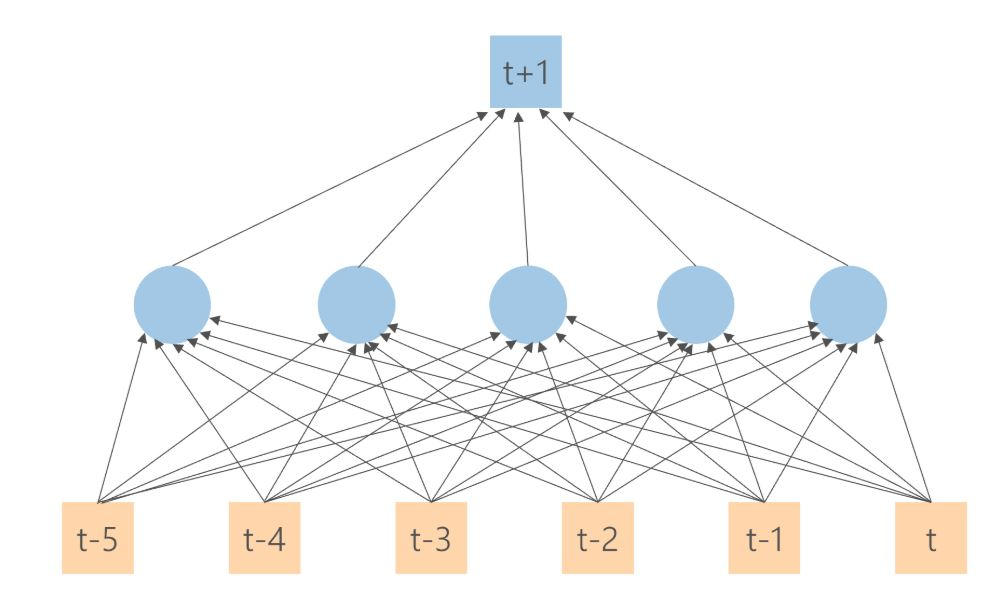

In [56]:
Image('images/ff_one_step_univariate.JPG')

In [57]:
from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [58]:
LATENT_DIM = 5 # number of units in the dense layer
BATCH_SIZE = 32 # number of samples per mini-batch
EPOCHS = 50 # maximum number of times the training algorithm will cycle through all samples

In [59]:
model = Sequential()
model.add(Dense(LATENT_DIM, activation="relu", input_shape=(T,)))
model.add(Dense(HORIZON))

W0301 00:22:08.902224 53640 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0301 00:22:08.930223 53640 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0301 00:22:08.936269 53640 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [61]:
model.compile(optimizer='RMSprop', loss='mse')

W0301 00:22:25.108612 53640 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [62]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 35        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [224]:
model.compile(optimizer='Adam', loss='mse')

## Early Stopping Trick

Specify the early stopping criteria. 

We monitor the validation loss (in this case the mean squared error) on the validation set after each training epoch. If the validation loss has not improved by min_delta after patience epochs, we stop the training.

In [64]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [65]:
best_val = ModelCheckpoint('model_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [66]:
history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop, best_val],verbose=1)

W0301 00:23:02.702104 53640 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0301 00:23:02.709084 53640 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 23370 samples, validate on 1463 samples
Epoch 1/50
23370/23370 [==============================] - 1s 31us/step - loss: 0.0059 - val_loss: 0.0032
Epoch 2/50
23370/23370 [==============================] - 1s 25us/step - loss: 0.0015 - val_loss: 0.0025
Epoch 3/50
23370/23370 [==============================] - 1s 26us/step - loss: 0.0013 - val_loss: 0.0022
Epoch 4/50
23370/23370 [==============================] - 1s 24us/step - loss: 0.0012 - val_loss: 0.0020
Epoch 5/50
23370/23370 [==============================] - 1s 24us/step - loss: 0.0011 - val_loss: 0.0019
Epoch 6/50
23370/23370 [==============================] - 1s 26us/step - loss: 0.0011 - val_loss: 0.0019
Epoch 7/50
23370/23370 [==============================] - 1s 38us/step - loss: 0.0010 - val_loss: 0.0018
Epoch 8/50
23370/23370 [==============================] - 1s 39us/step - loss: 9.9359e-04 - val_loss: 0.0017
Epoch 9/50
23370/23370 [==============================] - 1s 32us/step - loss: 9.5988e-04 - val_loss: 0.001

-  Load the model with the smallest mape

In [67]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights("model_{:02d}.h5".format(best_epoch))

- plot training and validation losses

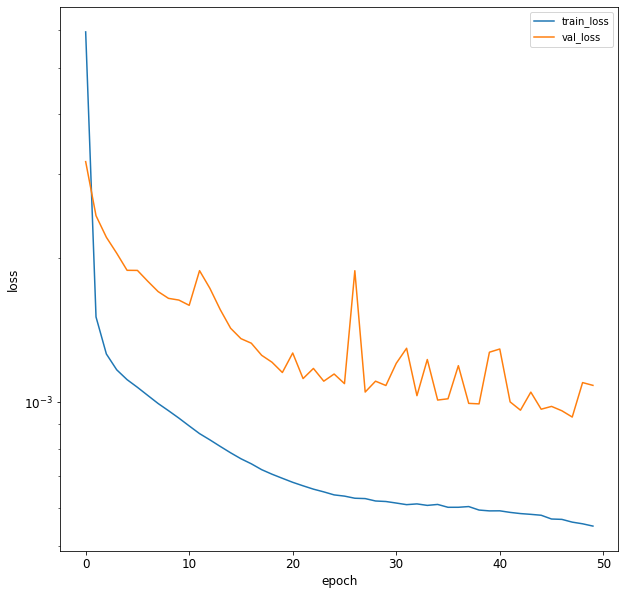

In [68]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

## Evaluate the model

- Create the test set

In [69]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load']]
test.head()

,load
2014-11-01 00:00:00,"2,514.00"
2014-11-01 01:00:00,"2,434.00"
2014-11-01 02:00:00,"2,390.00"
2014-11-01 03:00:00,"2,382.00"
2014-11-01 04:00:00,"2,419.00"


- Scale the test data

In [70]:
test['load'] = scaler.transform(test)
test.head()

,load
2014-11-01 00:00:00,0.12
2014-11-01 01:00:00,0.09
2014-11-01 02:00:00,0.07
2014-11-01 03:00:00,0.06
2014-11-01 04:00:00,0.08


- Create test set features

In [71]:
# 3. Shift the values of the time series to create a Pandas dataframe containing all the data 
# for a single validation example
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['load'].shift(-1, freq='H')

for t in range(1, T+1):
    test_shifted['load_t-'+str(T-t)] = test_shifted['load'].shift(T-t, freq='H')
# drop any "na" values
test_shifted = test_shifted.dropna(how='any')

#4.  Transform to numpy arrays for input keras
#4.1 Output variables: Targets
y_test = test_shifted['y_t+1'].values
#4.2 Input variables: Targets
X_test = test_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].values
#X_test = X_test[... , np.newaxis]

### Make predictions

- Prediction

In [72]:
predictions = model.predict(X_test)
predictions

array([[0.19],
       [0.3 ],
       [0.41],
       ...,
       [0.63],
       [0.53],
       [0.48]], dtype=float32)

- Compare Prediction to Actual Load

In [73]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,681.83","2,714.00"
1,2014-11-01 06:00:00,t+1,"2,936.16","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,185.95","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,321.95","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,447.69","3,436.00"


- Compute the mean absolute percentage error over all predictions

In [74]:
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return ((predictions - actuals).abs() / actuals).mean()

In [75]:
mape(eval_df['prediction'], eval_df['actual'])

0.01497577709695099

- Plot the predictions vs the actuals for the first week of the test set

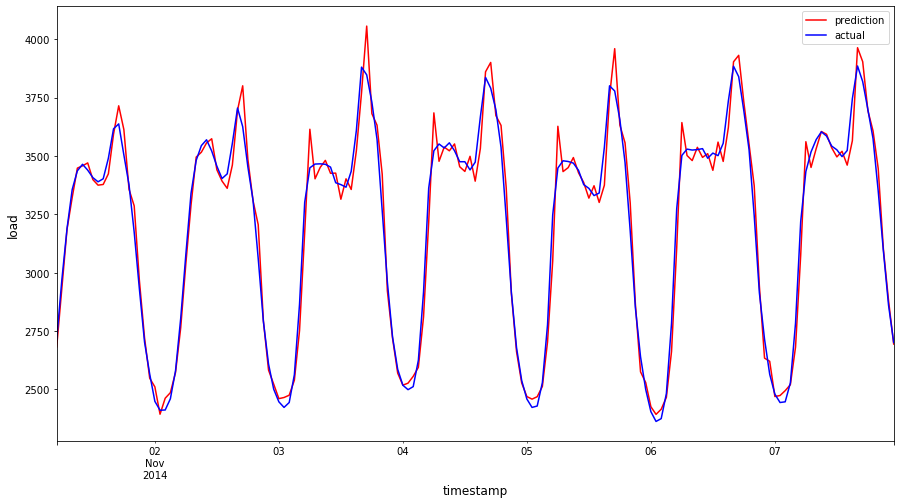

In [76]:
eval_df[eval_df.timestamp<'2014-11-08'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [77]:
for m in glob('model_*.h5'):
    os.remove(m)